## Time series forecasting fundamentals with Tensorflow + Milestone project 3: BitPredict

Let's write some tensorflow code to predict the price of bitcoin based on the historical price of bitcoin

**Note:** This is not financial advice

Link:
* Resource: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb

In [1]:
!pip install tensorflow==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 37.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-server-0.7.0
  Attempting uninstall: google-auth-oauthlib
    Fo

## Get data

We're going to be using the historical price data of bitcoin to try and predict the future price of bitcoin, we downloaded the data from here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-05-10 05:13:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2023-05-10 05:13:38 (7.37 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series data with pandas


In [3]:
#import with pandas

import pandas as pd

#let's read in our Bitcoin data and parse the date
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) #parse the date column and tell pandas column 1 is a date type
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
#how many samples do we have
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


We've collected the historical price of Bitcoin for the past 8 years but there's only 2787 samples.

Typically, deep learning models usually like lots and lots of samples(where lots and lots can be thousands to tens of thousands to millions).

A small number of samples is something you'll often run into with time series data problems

> **Note**: the **seasonality** of a time series dataset is referred as the number of samples per year. So for our bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year

In [6]:
len(df)

2787

In [7]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [8]:
#only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns = {"Closing Price (USD)": "Price"})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


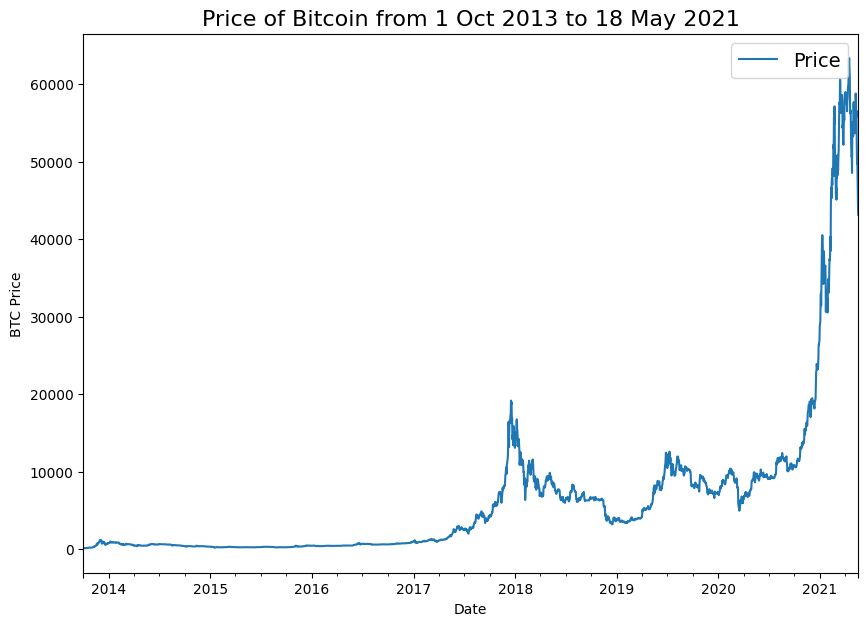

In [9]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize = (10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize = 16)
plt.legend(fontsize = 14)

##importing time series data with python's CSV module

In [10]:
import csv
from datetime import datetime
timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter = ",")
  next(csv_reader) #skip first line (get rid of the column headers)
  for row in csv_reader:
    timesteps.append(datetime.strptime(row[1], "%Y-%m-%d")) #get the dates as date not string
    btc_price.append(float(row[2])) #get the closing price as float


#View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

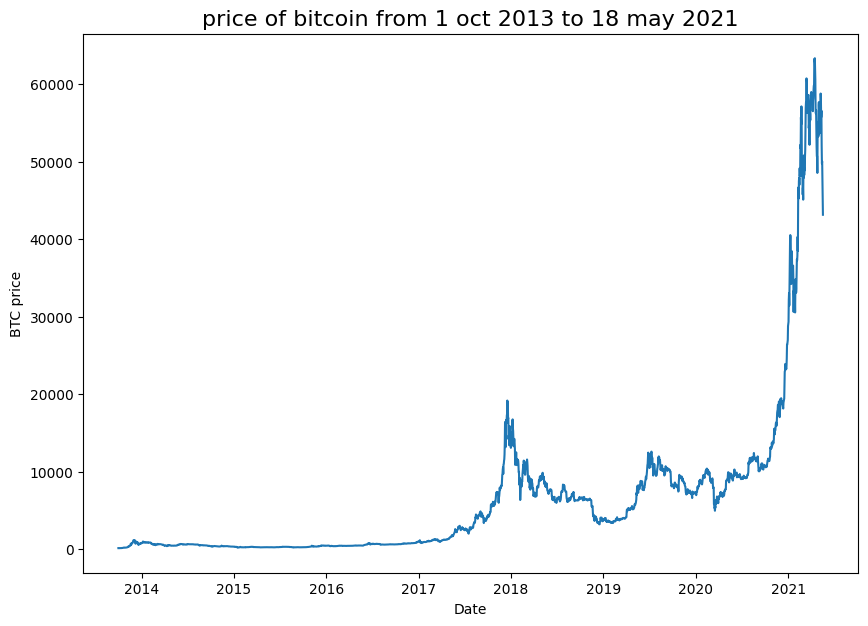

In [11]:
#plot from csv
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC price")
plt.title("price of bitcoin from 1 oct 2013 to 18 may 2021", fontsize = 16)
plt.xlabel("Date")


## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the **wrong way**)

In [12]:
#Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [13]:
#Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, #date
                                                    prices, #BTC price
                                                    test_size = 0.2,
                                                    random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

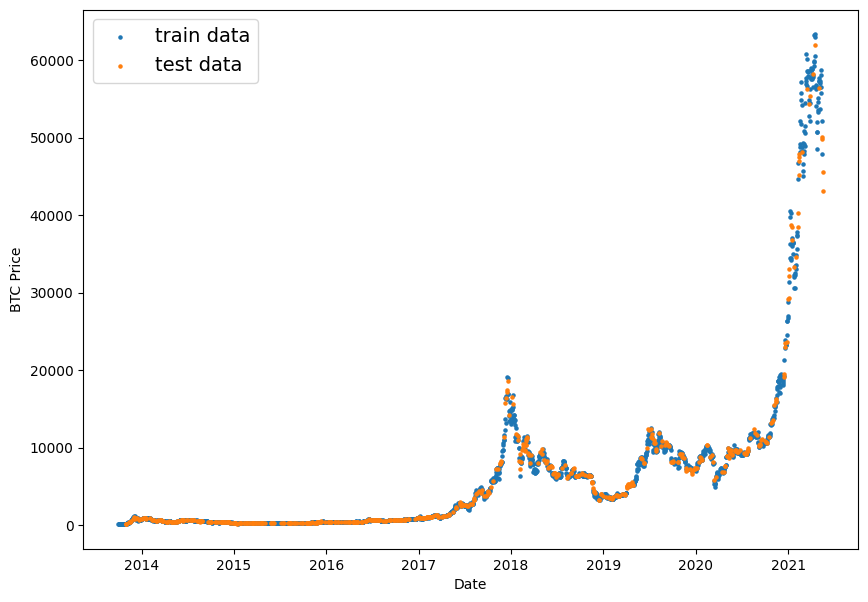

In [14]:
#Let's plot wrong train and test splits
plt.figure(figsize = (10,7))
plt.scatter(X_train, y_train, s = 5, label ="train data")
plt.scatter(X_test, y_test, s=5, label = "test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize = 14)
plt.show()

### Create train and test sets for time series (the **right** way)

In [15]:
# Create train and test split the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can change these values as needed, e.g. 90/10, 95/5

#Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]


#Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

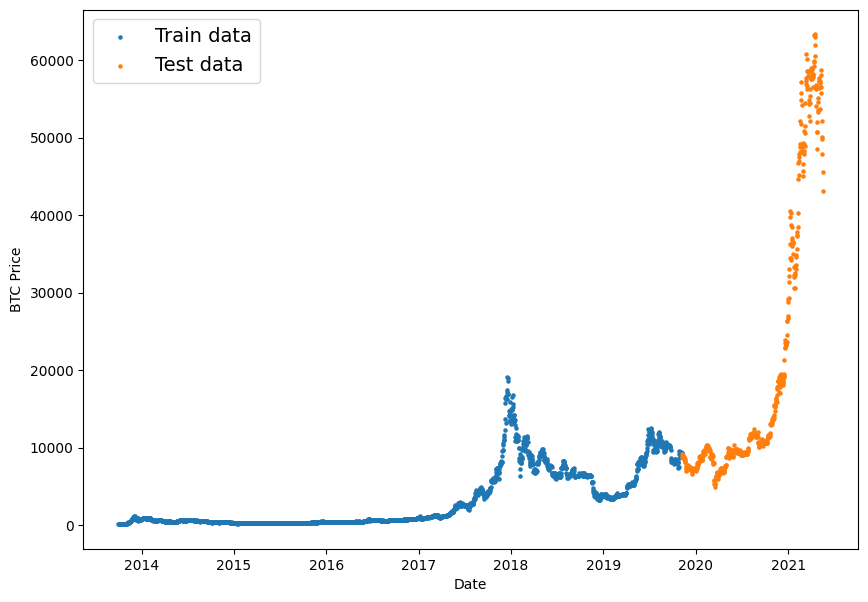

In [16]:
#plot correctly made splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label = "Train data")
plt.scatter(X_test, y_test, s=5, label = "Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize = 14)
plt.show()

##Create a plotting function
typing plotting code is tedious, let's functionize it.

In [17]:
#Create a function to plot time series data
def plot_time_series(timesteps, values, format = ".", start = 0, end = None, label = None):
  
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps)


  Parameters
  -----------
  timesteps: array of timesteps values
  values: array of values across time
  format: style of plot, default "."
  start: where to start the plot (setting the value will index from start of timesteps and values)
  end: where the end the plot(similar to start but for the end)
  label: label to show on plot about values, default None
  """
  
  #plot the series
  
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC_Price")
  if label:
    plt.legend(fontsize = 14) # make label bigger
  plt.grid(True)


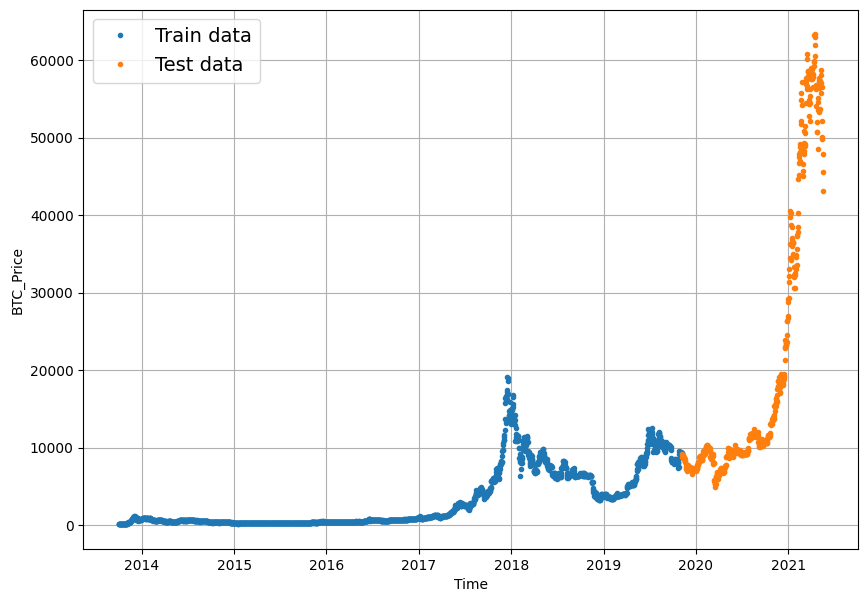

In [18]:
#Test our plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps = X_train, values = y_train, label = "Train data")
plot_time_series(timesteps = X_test, values = y_test, label = "Test data")

##Modelling experiments


We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.


Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **Horizion**


Modelling experiments we're running:

* 0	Naïve model (baseline)	
* 1	Dense model	, horizon = 1, window = 7
* 2	Same as 1, horizon = 1, window = 30
* 3	Same as 1, horizon = 7, window = 30
* 4	Conv1D	 
* 5	LSTM	
* 6	Same as 1 (but with multivariate data)	
* 7	N-BEATs Algorithm	
* 8	Ensemble (multiple models optimized on different loss functions)	
* 9	Future prediction model (model to predict future values)	
* 10	Same as 1 (but with turkey 🦃 data introduced)	

## Model 0: Naive forecase (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$


in English: 

> The prediction at timestep t (y-hat) is equal to the value at timesteps t-1 (previous timestep) - this is for a horizon of 1.

In [19]:
#Create a naive forcast
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [20]:
y_test[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

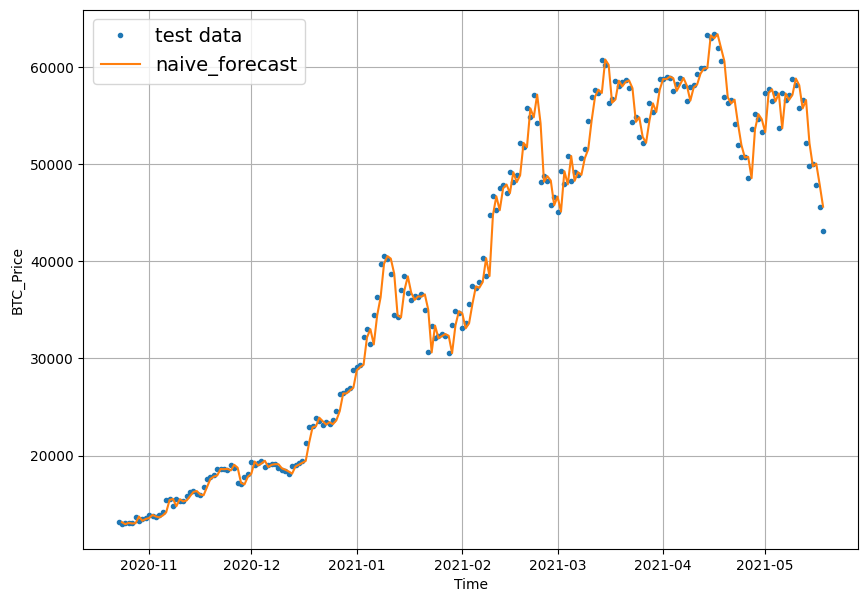

In [21]:
#Plot naive forecast
plt.figure(figsize = (10,7))
# plot_time_series(timesteps = X_train, values = y_train, label="train data")
plot_time_series(timesteps = X_test, values = y_test, start = 350, label = "test data")
plot_time_series(timesteps = X_test[1:], values = naive_forecast, start = 350, format = "-", label = "naive_forecast")

> **Exercise:** spend 10 minutes reading the simple forecasts chapter of Forecasting: principles in practice, and have a search to find out why the naive forecast is hard to beat, does the term augoregressive come up?

## Evaluating a time series model

Let's look into some evaluation metrics for time series forcasting.

What are we doing?

we're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metric.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

for all of the aboce metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100

The main thing we're evaluating here is: how do our model's forecasts (y_pred) compare against the acutual values (y_true or ground truth values)?


In [22]:
import tensorflow as tf



In [23]:
#MASE implementation

def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonaility of data).

  
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  #find the MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)
  return mae/mae_naive_no_season

In [24]:
mean_absolute_scaled_error(y_test[1:], naive_forecast).numpy()

0.9995699939182624

In [25]:
# Create a function to take in model predictions and truth value and return evaluation metrics

def evaluate_preds(y_true, y_pred):
  #make sure float32 datatype (for metric calcuations)
  y_true = tf.cast(y_true, dtype = tf.float32)
  y_pred = tf.cast(y_pred, dtype = tf.float32)

  #calculate various evaluation metrics
  mae = tf.keras.metrics. mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

That's one good looking evaluation function!

let's now see if it works...

In [26]:
naive_results = evaluate_preds(y_true = y_test[1:],
                               y_pred = naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [27]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737222>

In [28]:
tf.reduce_max(y_test), tf.reduce_min(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>,
 <tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>)

## other model you can use for baseline and for actual forcasts

in this notebook, we're focused on Tensorflow and deep learning models.

However there are plenty of other styles of time series models you may want to experiment with:
https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baseline-and-actual-forecasts

## Format data part 2: windowing our dataset

Why do we window?

we window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for 1 week
[0,1,2,3,4,5,6] -> [7]
[1,2,3,4,5,6,7] -> [8]
[2,3,4,5,6,7,8] -> [9]
```

In [29]:
len(y_train)

2229

In [30]:
#what we want to do with our bitcoin data
print(f"we want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

we want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [31]:
#let's set up global variable for window and horizon size
HORIZON = 1 #predict next 1 day
WINDOW_SIZE = 7 # use the past week of bitcoin data to make the prediction

In [32]:
#create function to label windowed data
def get_labelled_windows(x, horizon = HORIZON):
  """
  Creates labels for windowed dataset
  

  e.g. if horizon = 1
  input: [1,2,3,4,5,6,7] -> output: ([0,1,2,3,4,5,6],[7])
  """
  return x[:, :-horizon], x[:, -horizon:]


In [33]:
# test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis = 0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> label: 7


We've got a way to label our windowed data

However, this only on a small scale.

We need a way to do the above across our entire time series.

We could do this with python for loop, however for large time series, that would be quite slow.

To speed things up, we'll leverage NumPy's array indexing.

our function will:
1. create a window step of specific window size (e.g. [0,1,2,3,4,5,6])
2. use numpy indexing to create a 2D array of multiple window steps, for example:
```
[[0,1,2,3,4,5,6],
[1,2,3,4,5,6,7],
[2,3,4,5,6,7,8]]
```
3. Use the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of bitcoin)

4. Uses our `get_labelled_windows()` function we created above to turn the windows steps into window win a specified horizon

>**resource:** The function we're about to create has been adapted from the following article (fast and robust sliding window vectorization with numpy - toward data scient)



In [34]:
#create function to view numpy arrays as windows
def make_windows(x, window_size = WINDOW_SIZE, horizon = HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled window of window_size with horizon size labels.
  
  """

  #1. create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis = 0)

  #2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size + horizon-1)), axis = 0).T #create 2D array of windows of size WINDOW_SIZE

  # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

  #3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # print(windowed_array)

  #4 get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon = horizon)
  return windows, labels


In [35]:
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)

len(full_windows), len(full_labels)

(2780, 2780)

In [36]:
#View the first 3 windows/labels

for i in range(3):
  print(f"Window:{full_windows[i-3]} -> label: {full_labels[i-3]}")

Window:[58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> label: [47885.62525472]
Window:[58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> label: [45604.61575361]
Window:[55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> label: [43144.47129086]


> **Note:** There's a function does similiar to the above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the premade function named 
`timeseries_dataset_from_array`


## Turning windows into training and test sets

In [37]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [38]:
# Make the train/test splits

def make_train_test_splits(windows, labels, test_split = 0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """

  split_size = int(len(windows) * (1-test_split)) #this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [39]:
#Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

len(train_windows), len(test_windows), train_labels.shape, test_labels.shape

(2224, 556, (2224, 1), (556, 1))

In [40]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [41]:
#Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances

for example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the Tensorflow ModelCheckpoint

In [42]:
import os 

#create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path = "model_experiment"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                            monitor = "val_loss",
                                            verbose = 0, #only output a limited amount of text,
                                            save_best_only = True)

##model 1: Dense model (window = 7, horizon  = 1)

our first deep model is going to be a simple Dense model:

* a single dense layer with 128 hidden units and ReLu
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128 (previously we've used 32) (since the data this time is smaller in compare with image data)
* 100 epochs

Why these values? 

I picked them out of experimentation

* *Hyperparameters* =  values a machine learning practitioner(you) can adjust themselves
* *Parameters:* values a model learns on its own

In [43]:
import tensorflow as tf
from tensorflow.keras import layers

#set random seed for as reproducible results as possible
tf.random.set_seed(42)

#1. Construct model:
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON, activation = "linear") # linear activation is the same as having no activation
], name = "model_1_dense") #name our model so we can save it

#2. Compile 
model_1.compile(loss = "mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae", "mse"])

#3. Fit the model
model_1.fit(x = train_windows,
            y = train_labels,
            epochs = 100,
            verbose = 1,
            batch_size = 128,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_1.name)])

Epoch 1/100
18/18 [==============================] - 5s 57ms/step - loss: 780.3453 - mae: 780.3453 - mse: 2312725.7500 - val_loss: 2279.6533 - val_mae: 2279.6533 - val_mse: 12772734.0000
Epoch 2/100
18/18 [==============================] - 1s 54ms/step - loss: 247.6756 - mae: 247.6756 - mse: 285481.1875 - val_loss: 1005.9992 - val_mae: 1005.9992 - val_mse: 3441832.5000
Epoch 3/100
18/18 [==============================] - 1s 43ms/step - loss: 188.4116 - mae: 188.4116 - mse: 171891.6406 - val_loss: 923.2861 - val_mae: 923.2861 - val_mse: 2868220.2500
Epoch 4/100
18/18 [==============================] - 1s 45ms/step - loss: 169.4340 - mae: 169.4340 - mse: 151700.5781 - val_loss: 900.5871 - val_mae: 900.5871 - val_mse: 2683715.2500
Epoch 5/100
18/18 [==============================] - 1s 49ms/step - loss: 165.0895 - mae: 165.0895 - mse: 145490.8125 - val_loss: 895.2237 - val_mae: 895.2237 - val_mse: 2564574.5000
Epoch 6/100
18/18 [==============================] - 1s 49ms/step - loss: 158.5

In [44]:
#evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9760 - mae: 585.9760 - mse: 1197802.7500


[585.9759521484375, 585.9759521484375, 1197802.75]

In [45]:
model_1 = tf.keras.models.load_model("model_experiment/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.9512 - mae: 568.9512 - mse: 1171744.2500


[568.951171875, 568.951171875, 1171744.25]

##Making forecasts with a model (on the test dataset)

To make "forecast" on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because
actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Take in some input data (same kind of data the model was trained on)
3. Passes the input data into the model's `predict()` method
4. Returns the predictions

In [46]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) #return 1D array of predictions

In [47]:
#make predictions using model_1 on the test dataset and check the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.712, 8769.886, 9015.711, 8795.518, 8723.812, 8730.11 ,
        8691.951, 8502.054, 8460.961, 8516.548], dtype=float32)>)

In [48]:
model_1_preds.shape

TensorShape([556])

In [49]:
test_labels.shape

(556, 1)

In [50]:
#evaluate preds
model_1_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_1_preds)

In [51]:
model_1_results

{'mae': 568.9511,
 'mse': 1171744.4,
 'rmse': 1082.4714,
 'mape': 2.5448983,
 'mase': 0.99948955}

In [52]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [53]:
X_test[:10]

array(['2019-11-08T00:00:00.000000000', '2019-11-09T00:00:00.000000000',
       '2019-11-10T00:00:00.000000000', '2019-11-11T00:00:00.000000000',
       '2019-11-12T00:00:00.000000000', '2019-11-13T00:00:00.000000000',
       '2019-11-14T00:00:00.000000000', '2019-11-15T00:00:00.000000000',
       '2019-11-16T00:00:00.000000000', '2019-11-17T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [54]:
test_windows[:10]

array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
        9335.75240233, 9226.48582088, 8794.35864452],
       [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
        9226.48582088, 8794.35864452, 8798.04205463],
       [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
        8794.35864452, 8798.04205463, 9081.18687849],
       [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
        8798.04205463, 9081.18687849, 8711.53433917],
       [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
        9081.18687849, 8711.53433917, 8760.89271814],
       [9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102],
       [8794.35864452, 8798.04205463, 9081.18687849, 8711.53433917,
        8760.89271814, 8749.52059102, 8656.97092235],
       [8798.04205463, 9081.18687849, 8711.53433917, 8760.89271814,
        8749.52059102, 8656.97092235, 8500.64355816],
       [9081.18687849, 8

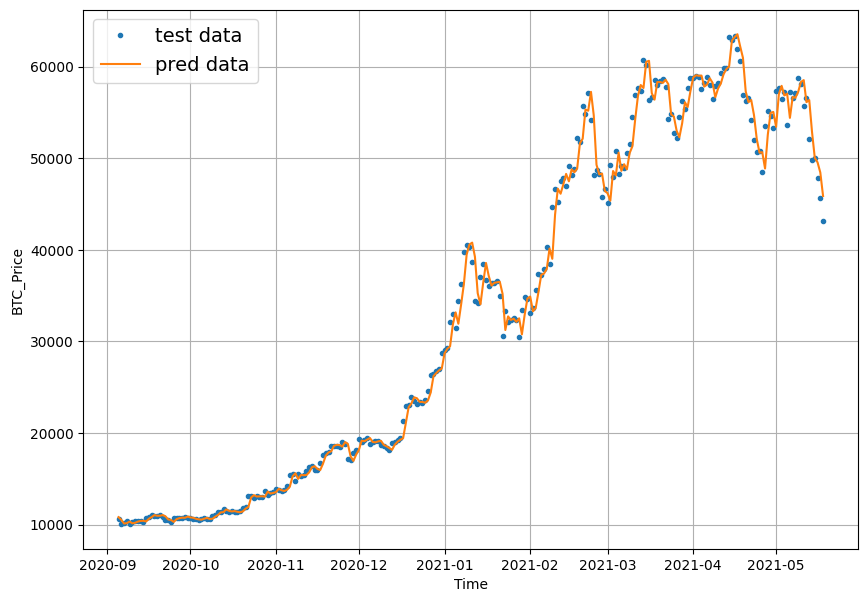

In [55]:
#let's plot our model 1 predictions
offset = 300
plt.figure(figsize = (10,7))
# plot_time_series(timesteps = X_train, values = y_train, label = "train_data")
#account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps = X_test[-len(test_windows):], values = test_labels[:, 0], start = offset , label = "test data")
plot_time_series(timesteps = X_test[-len(test_windows):], values = model_1_preds, start = offset ,format = "-", label = "pred data")

##Model 2: Dense (window = 30, horizon = 1)


In [56]:
HORIZON = 1 # predict one step at a time (one day of bitcoin prices)
WINDOW_SIZE = 30 #use 30 timesteps in past


In [57]:
#Make windows data with appropriate horizon and window size
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)

In [58]:
len(full_windows), len(full_labels)

(2757, 2757)

In [59]:
#make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows = full_windows,
                                                                                labels = full_labels,
                                                                                test_split = 0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [60]:
train_windows.shape

(2205, 30)

In [61]:
tf.random.set_seed(42)
#Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON)
], name = "model_2_dense")

#compile
model_2.compile(loss = "mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae", "mse"])

#fit
model_2.fit(train_windows,
            train_labels,
            epochs = 100,
            batch_size = 128,
            verbose = 0,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_2.name)])

In [62]:
#evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 618.4594 - mae: 618.4594 - mse: 1305625.0000


[618.4593505859375, 618.4593505859375, 1305625.0]

In [63]:
#load in the best performing model
model_2 = tf.keras.models.load_model("/content/model_experiment/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 616.4043 - mae: 616.4043 - mse: 1311550.5000


[616.404296875, 616.404296875, 1311550.5]

In [64]:
#get forecast predictions
model_2_preds = make_preds(model_2, input_data = test_windows)

In [65]:
#Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_2_preds)

In [66]:
model_2_results

{'mae': 616.4043,
 'mse': 1311550.4,
 'rmse': 1145.2294,
 'mape': 2.7673385,
 'mase': 1.0774808}

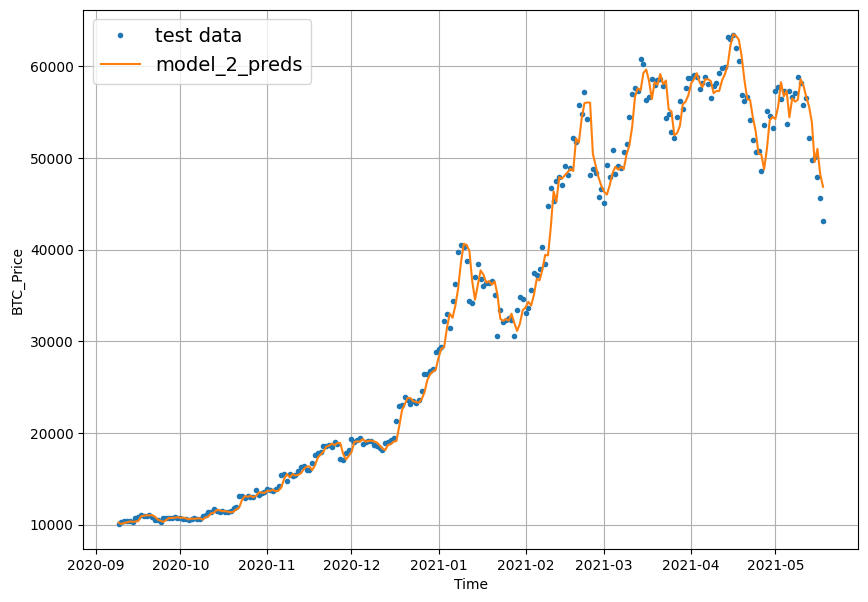

In [67]:
offset = 300
plt.figure(figsize = (10,7))
#account for test_window offset when plotting
plot_time_series(timesteps = X_test[-len(test_windows):], values = test_labels[:,0], start = offset, label = "test data")
plot_time_series(timesteps = X_test[-len(test_windows):], values = model_2_preds, start = offset, format = "-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)



In [68]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon =HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [69]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows = full_windows,
                                                                                labels = full_labels)
len(train_windows), len(test_windows) , len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [70]:
tf.random.set_seed(42)

#Create model same as model 1 except with different data input and output sizes

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON)
], name = "model_3_dense")

#Compile
model_3.compile(loss = "mae",
                optimizer = tf.keras.optimizers.Adam())

#fit 
model_3.fit(train_windows,
            train_labels,
            batch_size = 128,
            epochs = 100,
            verbose = 0,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_3.name)])


In [71]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1300.1522


1300.1522216796875

In [72]:
#load best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiment/model_3_dense")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1237.5063


1237.50634765625

In [73]:
#Make predictions with model 3
model_3_preds = make_preds(model_3,
                           input_data = test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9004.694 , 9048.1   , 9425.09  , 9258.256 , 9495.797 , 9558.453 ,
        9357.3545],
       [8735.506 , 8840.303 , 9247.793 , 8885.601 , 9097.186 , 9174.327 ,
        9156.818 ],
       [8672.508 , 8782.387 , 9123.857 , 8770.371 , 9007.13  , 9003.869 ,
        9042.725 ],
       [8874.399 , 8784.74  , 9043.902 , 8943.052 , 9033.477 , 9176.489 ,
        9039.677 ],
       [8825.89  , 8777.44  , 8926.78  , 8870.179 , 9213.232 , 9268.156 ,
        8942.487 ]], dtype=float32)>

In [74]:
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8874.105, 8898.818, 8752.713, 8553.506, 8421.086], dtype=float32)>

In [75]:
#Evaluate model_3 results
model_3_results = evaluate_preds(tf.squeeze(test_labels),
                                 model_3_preds)

## Make our evaluation function work for larger horizons

In [76]:
model_3_results["mae"]

array([ 513.6056  ,  355.08328 ,  327.17075 ,  358.5106  ,  420.53293 ,
        537.854   ,  545.6617  ,  485.9228  ,  584.49713 ,  687.38214 ,
        836.2264  ,  755.1576  ,  731.4957  ,  775.3399  ,  567.95544 ,
        266.80865 ,  188.80217 ,  188.10805 ,  253.095   ,  301.43256 ,
        151.10721 ,  196.8148  ,  191.46178 ,  231.65031 ,  143.61125 ,
        122.59089 ,  132.78871 ,  190.81174 ,  179.15994 ,  228.26004 ,
        314.44022 ,  379.09235 ,  278.32526 ,  295.34702 ,  299.3852  ,
        248.64983 ,  299.75668 ,  259.69434 ,  180.30531 ,  206.72922 ,
        374.62863 ,  144.85086 ,  142.33635 ,  131.11613 ,   93.9412  ,
         54.825542,   73.79555 ,  103.60121 ,  121.333916,  168.67278 ,
        183.90945 ,  152.25307 ,  186.57199 ,  146.91273 ,  240.42912 ,
        351.00656 ,  540.952   ,  549.1573  ,  521.2411  ,  526.8554  ,
        453.36237 ,  257.9811  ,  277.2947  ,  301.8247  ,  455.718   ,
        458.9603  ,  503.4438  ,  522.3119  ,  223.07631 ,  250.

In [77]:
# Create a function to take in model predictions and truth value and return evaluation metrics

def evaluate_preds(y_true, y_pred):
  #make sure float32 datatype (for metric calcuations)
  y_true = tf.cast(y_true, dtype = tf.float32)
  y_pred = tf.cast(y_pred, dtype = tf.float32)

  #calculate various evaluation metrics
  mae = tf.keras.metrics. mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  #account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae =  tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [78]:
#get model_3_results aggregated to a single value
model_3_results =evaluate_preds(test_labels,
                                model_3_preds)

In [79]:
model_3_results

{'mae': 1237.5063,
 'mse': 5405198.5,
 'rmse': 1425.7477,
 'mape': 5.5588784,
 'mase': 2.2020733}

We've made and evaluated prediction with model_3, let's visualize

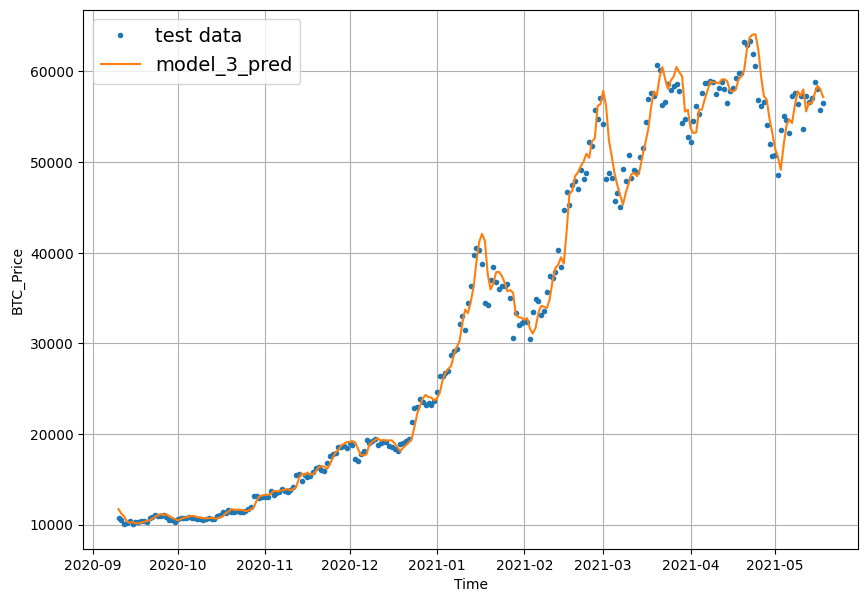

In [80]:
offset = 300
plt.figure(figsize = (10,7))
plot_time_series(timesteps = X_test[-len(test_windows):], values = test_labels[:,0], start=offset, label = "test data")
plot_time_series(timesteps = X_test[-len(test_windows):], values = tf.reduce_mean(model_3_preds, axis = 1), format = "-", start = offset, label = "model_3_pred")

In [81]:
##Which of our models is performing the best so far


In [82]:
import pandas as pd
all_models_results = pd.DataFrame({"model_0_naive": naive_results["mae"],
                                   "model_1_dense": model_1_results["mae"],
                                   "model_2_dense": model_2_results["mae"],
                                   "model_3_dense": model_3_results["mae"]},index = ["mae"])

In [83]:
all_models_results = all_models_results.transpose()
all_models_results

,mae
model_0_naive,567.980225
model_1_dense,568.951111
model_2_dense,616.404297
model_3_dense,1237.506348


<Axes: >

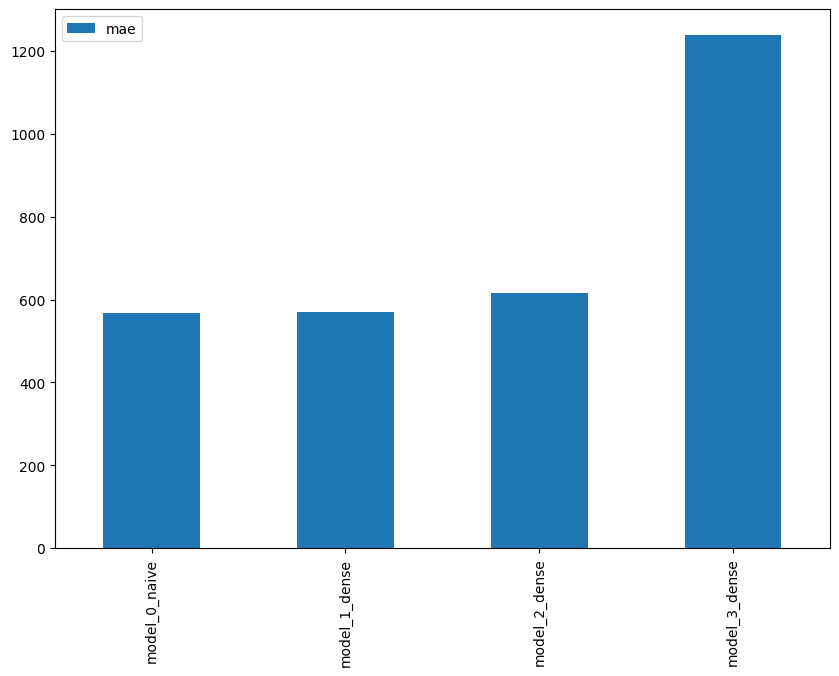

In [84]:
all_models_results.plot(figsize = (10,7), kind = "bar")

>**Note:** You might wondering why are the naive results so good? one of the reasons could be due to presence of autocorrelation it means the value at t+1 (the next timestep) is typically close to the value at t (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Ofcourse, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naive model will often get fairly good results

## Model 4: conv1D

In [85]:
HORIZON = 1
WINDOW_SIZE = 7

full_windows, full_labels = make_windows(prices)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

To use the Conv1D layer, we need an input shape of: (`batch_size`, `timesteps`, `input_dim`)...

However our data isn't in that shape yet...

In [86]:
#Check data input shape
train_windows[0].shape #returns (WINDOW_SIZE, )

(7,)

In [87]:
#Before we pass our data to the conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [88]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis = 1)) #add an extra dim for input dim

In [89]:
#test out our lambda layer
print(f"Original shape: {x.shape}") #(window_size)
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")


Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [90]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    
    layers.Lambda(lambda x: tf.expand_dims(x, axis = 1)),
    layers.Conv1D(128, 7, padding= "causal", activation ="relu"),
    # layers.GlobalAveragePooling1D(),
    layers.Dense(HORIZON)

], name = "model_4_conv1D")


model_4.compile(loss = "mae",
                optimizer = tf.keras.optimizers.Adam())


model_4.fit(train_windows,
            train_labels,
            epochs = 100,
            batch_size = 128,
            verbose = 0,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_4.name)])

In [91]:
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 613.8751


613.8751220703125

In [92]:
#load back best performing conv1d model and evaluate
model_4 = tf.keras.models.load_model("/content/model_experiment/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 570.7238


570.7237548828125

In [93]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            6400      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [94]:
#Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8894.377 , 8788.778 , 9019.8125, 8795.952 , 8743.677 , 8765.776 ,
       8680.058 , 8539.173 , 8475.881 , 8526.665 ], dtype=float32)>

In [95]:
#evaluate predictions
model_4_results = evaluate_preds(tf.squeeze(test_labels),
                                 model_4_preds)

In [96]:
model_4_results

{'mae': 570.7237,
 'mse': 1183346.4,
 'rmse': 1087.8173,
 'mape': 2.5466611,
 'mase': 1.0026034}

In [97]:
model_1_results

{'mae': 568.9511,
 'mse': 1171744.4,
 'rmse': 1082.4714,
 'mape': 2.5448983,
 'mase': 0.99948955}

##Model_5: RNN (LSTM)

let's build an rnn model for our time series data.

we'll use the same data we created previously

In [98]:
tf.random.set_seed(42)


#let build a lstm model with the functional API
inputs = layers.Input(shape = (WINDOW_SIZE))
x = expand_dims_layer(inputs)
# x = layers.LSTM(128, return_sequences = True)(x)
x = layers.LSTM(128, activation = "relu")(x)



outputs = layers.Dense(HORIZON)(x)


model_5 = tf.keras.Model(inputs, outputs, name = "model_5_lstm")

#compile
model_5.compile(loss = "mae",
                optimizer = tf.keras.optimizers.Adam())

#fit
model_5.fit(train_windows,
            train_labels,
            epochs = 100,
            verbose = 1,
            batch_size = 128,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_5.name)])

Epoch 1/100
10/18 [===============>..............] - ETA: 0s - loss: 2581.3218 

18/18 [==============================] - 3s 97ms/step - loss: 2323.6082 - val_loss: 9222.6523
Epoch 2/100
12/18 [===================>..........] - ETA: 0s - loss: 905.2980 

18/18 [==============================] - 2s 121ms/step - loss: 695.4739 - val_loss: 1486.0555
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 237.3967

18/18 [==============================] - 2s 128ms/step - loss: 237.3967 - val_loss: 1298.9083
Epoch 4/100
16/18 [=========================>....] - ETA: 0s - loss: 182.2439

18/18 [==============================] - 2s 118ms/step - loss: 181.9180 - val_loss: 966.6431
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 173.4022 - val_loss: 970.9295
Epoch 6/100
11/18 [=================>............] - ETA: 0s - loss: 169.3568

18/18 [==============================] - 1s 85ms/step - loss: 173.5414 - val_loss: 941.4745
Epoch 7/100
11/18 [=================>............] - ETA: 0s - loss: 181.8447

18/18 [==============================] - 2s 109ms/step - loss: 170.3566 - val_loss: 898.5216
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 157.6712 - val_loss: 914.8643
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 166.1094 - val_loss: 1082.0688
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 169.3862 - val_loss: 1016.4379
Epoch 11/100
18/18 [==============================] - 0s 9ms/step - loss: 170.2337 - val_loss: 973.9583
Epoch 12/100
18/18 [==============================] - 0s 7ms/step - loss: 164.4142 - val_loss: 1062.2212
Epoch 13/100
18/18 [==============================] - 0s 7ms/step - loss: 162.5129 - val_loss: 904.5349
Epoch 14/100
18/18 [==============================] - 0s 7ms/step - loss: 157.9061 - val_loss: 923.5742
Epoch 15/100
13/18 [====================>.........] - ETA: 0s - loss: 155.1294

18/18 [==============================] - 1s 83ms/step - loss: 157.5421 - val_loss: 886.6829
Epoch 16/100
11/18 [=================>............] - ETA: 0s - loss: 154.8839

18/18 [==============================] - 1s 85ms/step - loss: 154.4286 - val_loss: 857.4166
Epoch 17/100
18/18 [==============================] - 0s 7ms/step - loss: 153.1222 - val_loss: 961.6697
Epoch 18/100
18/18 [==============================] - 0s 7ms/step - loss: 153.7906 - val_loss: 893.3588
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 148.7135 - val_loss: 860.2227
Epoch 20/100
11/18 [=================>............] - ETA: 0s - loss: 153.0908

18/18 [==============================] - 1s 84ms/step - loss: 149.2996 - val_loss: 828.6722
Epoch 21/100
11/18 [=================>............] - ETA: 0s - loss: 152.8041

18/18 [==============================] - 2s 114ms/step - loss: 145.2505 - val_loss: 819.3801
Epoch 22/100
18/18 [==============================] - ETA: 0s - loss: 143.4021

18/18 [==============================] - 3s 168ms/step - loss: 143.4021 - val_loss: 815.1205
Epoch 23/100
18/18 [==============================] - 0s 6ms/step - loss: 142.3459 - val_loss: 824.7785
Epoch 24/100
12/18 [===================>..........] - ETA: 0s - loss: 140.6125

18/18 [==============================] - 1s 83ms/step - loss: 140.7528 - val_loss: 794.9140
Epoch 25/100
11/18 [=================>............] - ETA: 0s - loss: 144.0518

18/18 [==============================] - 1s 85ms/step - loss: 138.1636 - val_loss: 786.2650
Epoch 26/100
12/18 [===================>..........] - ETA: 0s - loss: 137.6005

18/18 [==============================] - 1s 85ms/step - loss: 137.2727 - val_loss: 763.5402
Epoch 27/100
18/18 [==============================] - 0s 7ms/step - loss: 135.8884 - val_loss: 775.4518
Epoch 28/100
11/18 [=================>............] - ETA: 0s - loss: 137.4158

18/18 [==============================] - 2s 106ms/step - loss: 135.3953 - val_loss: 760.6052
Epoch 29/100
11/18 [=================>............] - ETA: 0s - loss: 136.8967

18/18 [==============================] - 1s 84ms/step - loss: 135.5748 - val_loss: 760.3422
Epoch 30/100
18/18 [==============================] - 0s 7ms/step - loss: 138.0088 - val_loss: 775.3551
Epoch 31/100
10/18 [===============>..............] - ETA: 0s - loss: 136.6098

18/18 [==============================] - 1s 86ms/step - loss: 132.5299 - val_loss: 727.9670
Epoch 32/100
 9/18 [==============>...............] - ETA: 0s - loss: 128.0849

18/18 [==============================] - 2s 113ms/step - loss: 128.6500 - val_loss: 725.8123
Epoch 33/100
17/18 [===========================>..] - ETA: 0s - loss: 129.9291

18/18 [==============================] - 3s 168ms/step - loss: 129.0425 - val_loss: 714.2305
Epoch 34/100
13/18 [====================>.........] - ETA: 0s - loss: 133.1402

18/18 [==============================] - 1s 87ms/step - loss: 127.8702 - val_loss: 706.1533
Epoch 35/100
11/18 [=================>............] - ETA: 0s - loss: 130.1779

18/18 [==============================] - 1s 86ms/step - loss: 125.8893 - val_loss: 699.7709
Epoch 36/100
10/18 [===============>..............] - ETA: 0s - loss: 120.3535

18/18 [==============================] - 1s 84ms/step - loss: 125.0943 - val_loss: 693.5330
Epoch 37/100
10/18 [===============>..............] - ETA: 0s - loss: 116.1057

18/18 [==============================] - 2s 113ms/step - loss: 123.8693 - val_loss: 687.4672
Epoch 38/100
12/18 [===================>..........] - ETA: 0s - loss: 126.3187

18/18 [==============================] - 1s 85ms/step - loss: 123.2803 - val_loss: 678.9265
Epoch 39/100
18/18 [==============================] - 0s 8ms/step - loss: 123.4690 - val_loss: 691.7551
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 122.9308 - val_loss: 683.6312
Epoch 41/100
12/18 [===================>..........] - ETA: 0s - loss: 124.1187

18/18 [==============================] - 1s 83ms/step - loss: 121.4353 - val_loss: 670.7870
Epoch 42/100
12/18 [===================>..........] - ETA: 0s - loss: 119.6596

18/18 [==============================] - 2s 105ms/step - loss: 120.8648 - val_loss: 663.5636
Epoch 43/100
16/18 [=========================>....] - ETA: 0s - loss: 122.7302

18/18 [==============================] - 3s 167ms/step - loss: 120.8071 - val_loss: 660.7370
Epoch 44/100
16/18 [=========================>....] - ETA: 0s - loss: 120.7615

18/18 [==============================] - 2s 97ms/step - loss: 120.5056 - val_loss: 657.0330
Epoch 45/100
10/18 [===============>..............] - ETA: 0s - loss: 122.1013

18/18 [==============================] - 1s 86ms/step - loss: 118.8850 - val_loss: 652.1992
Epoch 46/100
12/18 [===================>..........] - ETA: 0s - loss: 124.2053

18/18 [==============================] - 1s 84ms/step - loss: 118.8637 - val_loss: 648.5120
Epoch 47/100
18/18 [==============================] - 0s 8ms/step - loss: 118.8610 - val_loss: 649.7934
Epoch 48/100
10/18 [===============>..............] - ETA: 0s - loss: 115.4341

18/18 [==============================] - 2s 112ms/step - loss: 117.9048 - val_loss: 642.6136
Epoch 49/100
18/18 [==============================] - 0s 8ms/step - loss: 117.1534 - val_loss: 649.2055
Epoch 50/100
18/18 [==============================] - 0s 7ms/step - loss: 119.4507 - val_loss: 681.9903
Epoch 51/100
18/18 [==============================] - 0s 7ms/step - loss: 119.0045 - val_loss: 662.3359
Epoch 52/100
11/18 [=================>............] - ETA: 0s - loss: 124.2260

18/18 [==============================] - 1s 85ms/step - loss: 117.5628 - val_loss: 637.8365
Epoch 53/100
12/18 [===================>..........] - ETA: 0s - loss: 114.4723

18/18 [==============================] - 1s 87ms/step - loss: 116.9946 - val_loss: 631.6547
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 117.4809 - val_loss: 635.2073
Epoch 55/100
12/18 [===================>..........] - ETA: 0s - loss: 121.3978

18/18 [==============================] - 2s 117ms/step - loss: 115.7643 - val_loss: 628.1357
Epoch 56/100
18/18 [==============================] - 0s 12ms/step - loss: 118.1502 - val_loss: 634.6026
Epoch 57/100
18/18 [==============================] - 0s 12ms/step - loss: 123.7681 - val_loss: 638.8491
Epoch 58/100
18/18 [==============================] - 0s 13ms/step - loss: 115.4951 - val_loss: 634.1176
Epoch 59/100
15/18 [========================>.....] - ETA: 0s - loss: 115.2967

18/18 [==============================] - 3s 154ms/step - loss: 114.6518 - val_loss: 622.1254
Epoch 60/100
11/18 [=================>............] - ETA: 0s - loss: 114.5842

18/18 [==============================] - 1s 85ms/step - loss: 113.8603 - val_loss: 619.7850
Epoch 61/100
18/18 [==============================] - 0s 8ms/step - loss: 113.9733 - val_loss: 622.8787
Epoch 62/100
18/18 [==============================] - 0s 6ms/step - loss: 113.4767 - val_loss: 623.5634
Epoch 63/100
11/18 [=================>............] - ETA: 0s - loss: 120.4192

18/18 [==============================] - 1s 87ms/step - loss: 115.2042 - val_loss: 616.6463
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 112.7896 - val_loss: 645.9852
Epoch 65/100
18/18 [==============================] - 0s 8ms/step - loss: 115.0747 - val_loss: 619.3737
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 113.1905 - val_loss: 621.5306
Epoch 67/100
18/18 [==============================] - 0s 7ms/step - loss: 115.1236 - val_loss: 618.8363
Epoch 68/100
12/18 [===================>..........] - ETA: 0s - loss: 116.2020

18/18 [==============================] - 1s 84ms/step - loss: 116.4465 - val_loss: 610.9781
Epoch 69/100
18/18 [==============================] - 0s 7ms/step - loss: 117.7513 - val_loss: 622.7224
Epoch 70/100
18/18 [==============================] - 0s 8ms/step - loss: 116.5777 - val_loss: 614.9359
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 113.1809 - val_loss: 630.2724
Epoch 72/100
12/18 [===================>..........] - ETA: 0s - loss: 114.6839

18/18 [==============================] - 2s 110ms/step - loss: 115.4782 - val_loss: 606.1706
Epoch 73/100
18/18 [==============================] - 0s 7ms/step - loss: 111.8071 - val_loss: 608.0045
Epoch 74/100
18/18 [==============================] - 0s 7ms/step - loss: 113.4310 - val_loss: 610.6129
Epoch 75/100
18/18 [==============================] - 0s 7ms/step - loss: 114.5693 - val_loss: 688.2480
Epoch 76/100
18/18 [==============================] - 0s 7ms/step - loss: 114.7418 - val_loss: 633.4675
Epoch 77/100
18/18 [==============================] - 0s 7ms/step - loss: 114.2406 - val_loss: 663.2068
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 115.0829 - val_loss: 629.7468
Epoch 79/100
11/18 [=================>............] - ETA: 0s - loss: 108.8646

18/18 [==============================] - 2s 94ms/step - loss: 112.6453 - val_loss: 602.0507
Epoch 80/100
18/18 [==============================] - 0s 12ms/step - loss: 112.2274 - val_loss: 637.0703
Epoch 81/100
18/18 [==============================] - 0s 12ms/step - loss: 112.4878 - val_loss: 625.9257
Epoch 82/100
18/18 [==============================] - ETA: 0s - loss: 114.5328

18/18 [==============================] - 2s 128ms/step - loss: 114.5328 - val_loss: 599.3333
Epoch 83/100
18/18 [==============================] - 0s 14ms/step - loss: 111.9914 - val_loss: 617.7666
Epoch 84/100
18/18 [==============================] - 0s 15ms/step - loss: 113.3366 - val_loss: 613.6205
Epoch 85/100
18/18 [==============================] - 0s 13ms/step - loss: 111.7593 - val_loss: 632.4156
Epoch 86/100
18/18 [==============================] - 0s 12ms/step - loss: 114.1903 - val_loss: 612.9362
Epoch 87/100
18/18 [==============================] - 0s 13ms/step - loss: 112.7153 - val_loss: 600.3879
Epoch 88/100
18/18 [==============================] - ETA: 0s - loss: 110.9237

18/18 [==============================] - 2s 97ms/step - loss: 110.9237 - val_loss: 595.3619
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 111.0461 - val_loss: 634.4736
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 115.2480 - val_loss: 674.9190
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 115.8803 - val_loss: 638.7774
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 111.9520 - val_loss: 597.2429
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 111.4798 - val_loss: 613.3654
Epoch 94/100
18/18 [==============================] - 0s 7ms/step - loss: 111.4016 - val_loss: 607.8994
Epoch 95/100
12/18 [===================>..........] - ETA: 0s - loss: 107.7555

18/18 [==============================] - 2s 110ms/step - loss: 110.1672 - val_loss: 592.1991
Epoch 96/100
18/18 [==============================] - 0s 7ms/step - loss: 112.5459 - val_loss: 602.7871
Epoch 97/100
18/18 [==============================] - 0s 7ms/step - loss: 109.6958 - val_loss: 596.0212
Epoch 98/100
18/18 [==============================] - 0s 7ms/step - loss: 109.5396 - val_loss: 592.4672
Epoch 99/100
11/18 [=================>............] - ETA: 0s - loss: 107.4886

18/18 [==============================] - 1s 86ms/step - loss: 110.0278 - val_loss: 590.0786
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 117.3639 - val_loss: 653.5999


In [99]:
#Load in best version of model and evaluate on the test data
model_5 = tf.keras.models.load_model("/content/model_experiment/model_5_lstm")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 590.0787


590.0786743164062

In [100]:
#Make predictions with our LSTM model
model_5_preds = make_preds (model_5, test_windows)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8961.762, 8807.321, 9020.011, 8823.143, 8729.695], dtype=float32)>

In [101]:
#evaluate model 5 predictions
model_5_results = evaluate_preds(tf.squeeze(test_labels),
                                 y_pred = model_5_preds)
model_5_results

{'mae': 590.0787,
 'mse': 1245637.2,
 'rmse': 1116.0812,
 'mape': 2.656607,
 'mase': 1.0366048}

> **note:** Because neural networks are such powerfull algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve acceptable or usable results. you're probably starting to clue onto this now

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...

What's a better feature to use?

How about the bitcoin halving events?


In [102]:
#Let's make a multivariate time series

bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [103]:
#let's add bitcoin halving event to our dataset
block_reward_1 = 50 # 3 january 2009 - this block reward isn't in our dataset (it starts from 01 oct 2013 (our data))
block_reward_2 = 25 # 8 november 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 may 2020

#Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [104]:
block_reward_2_datetime

numpy.datetime64('2012-11-28')

In [105]:
#Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days


In [106]:
#add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

#add in block reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

<Axes: xlabel='Date'>

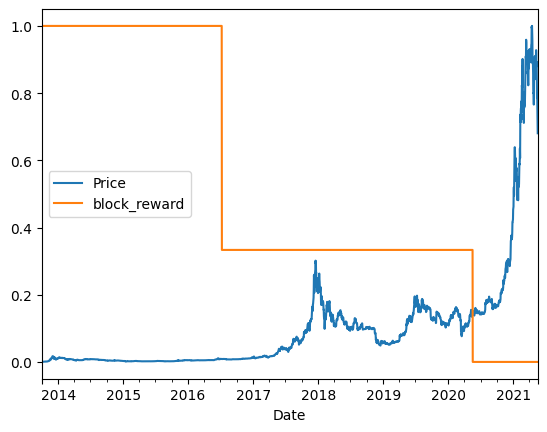

In [107]:
#plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns = bitcoin_prices_block.columns,
                                     index = bitcoin_prices_block.index)


scaled_price_block_df.plot()

## Making a windows dataset with pandas

Previously, we've turned our univariate time series into windowed dataset using the helper function above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data

In [108]:
#set up dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7


In [109]:
#make a copy of the bitcoin historical data with block reward feature

bitcoin_prices_windowed = bitcoin_prices_block.copy()

#add windowed columns
for i in range(WINDOW_SIZE): #shift values of each steps in window_size
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods = i+1)


bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [110]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0,1,2,3,4,5,6,block_reward] - > [7]
[1,2,3,4,5,6,7,block_reward] - > [8]
[2,3,4,5,6,7,8,block_reward] - > [9]
```

In [111]:
#Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis = 1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

X,y

(            block_reward       Price+1       Price+2       Price+3  \
 Date                                                                 
 2013-10-08         25.00    121.794998    120.655327    121.338661   
 2013-10-09         25.00    123.032997    121.794998    120.655327   
 2013-10-10         25.00    124.049004    123.032997    121.794998   
 2013-10-11         25.00    125.961159    124.049004    123.032997   
 2013-10-12         25.00    125.279663    125.961159    124.049004   
 ...                  ...           ...           ...           ...   
 2021-05-14          6.25  52147.820312  56573.554688  55715.546875   
 2021-05-15          6.25  49764.132812  52147.820312  56573.554688   
 2021-05-16          6.25  50032.691406  49764.132812  52147.820312   
 2021-05-17          6.25  47885.625000  50032.691406  49764.132812   
 2021-05-18          6.25  45604.617188  47885.625000  50032.691406   
 
                  Price+4       Price+5       Price+6       Price+7  
 Date

In [112]:
#Make train and test sets using indexing
split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariative time series)

In [113]:
tf.random.set_seed(42)
#make multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON)
], name = "model_6_dense_multivariate")

#compile
model_6.compile(loss = "mae",
                optimizer = tf.keras.optimizers.Adam())

#fit 
model_6.fit(X_train,
            y_train,
            epochs = 100,
            batch_size = 128,
            verbose = 1,
            validation_data = (X_test, y_test),
            callbacks = [create_model_checkpoint(model_name = model_6.name)])

Epoch 1/100
18/18 [==============================] - 1s 40ms/step - loss: 1234.6804 - val_loss: 2061.9077
Epoch 2/100
18/18 [==============================] - 1s 35ms/step - loss: 351.5054 - val_loss: 1908.6726
Epoch 3/100
18/18 [==============================] - 1s 34ms/step - loss: 235.4153 - val_loss: 1329.0585
Epoch 4/100
18/18 [==============================] - 1s 34ms/step - loss: 208.6112 - val_loss: 1102.1340
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 196.5770 - val_loss: 1107.8473
Epoch 6/100
18/18 [==============================] - 0s 25ms/step - loss: 187.2245 - val_loss: 1036.1720
Epoch 7/100
18/18 [==============================] - 0s 23ms/step - loss: 182.0246 - val_loss: 1019.2925
Epoch 8/100
18/18 [==============================] - 1s 45ms/step - loss: 175.7059 - val_loss: 977.8486
Epoch 9/100
18/18 [==============================] - 0s 24ms/step - loss: 170.1784 - val_loss: 954.4037
Epoch 10/100
18/18 [==============================] - 0s 

In [114]:
#evaluate multivariate model
model_6.evaluate(X_test, y_test)


18/18 [==============================] - 0s 2ms/step - loss: 654.9888


654.9888305664062

In [115]:
#load in and evaluate the best performing model
model_6 = tf.keras.models.load_model("/content/model_experiment/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 567.5862


567.586181640625

In [116]:
#make preidctions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8836.278, 8763.799, 9040.487, 8741.225, 8719.325, 8765.07 ,
       8661.102, 8496.892, 8463.23 , 8521.585], dtype=float32)>

In [117]:
model_6_results = evaluate_preds(y_test,
                                 model_6_preds)

In [118]:
model_6_results

{'mae': 567.5862,
 'mse': 1161687.2,
 'rmse': 1077.8159,
 'mape': 2.5413756,
 'mase': 0.9970917}

In [119]:
model_1_results

{'mae': 568.9511,
 'mse': 1171744.4,
 'rmse': 1082.4714,
 'mape': 2.5448983,
 'mase': 0.99948955}

For a challenge on different ways to potentially improve the multivariate time series model, see the reference here

##Model 7: N-BEATS algorithm

let's now build the bigest badass (though maybe no the baddest, as in, it perform really well) time series forecasting model we've built so far.

More specifically, we're going to be replicating the algorithm in the following paper: https://arxiv.org/abs/1905.10437

Why?

* this will allow us to practice replicating a paper with tensorflow code
* we will see how to use tensorflow layer subclassing (to make our own custom layers)
* Get experience using the Functial API to create a custom architecture
* Potentially get state of the art results on our problems

### Building and testing the N-Beats block layer

Because the N-Beats block layer doesn't exist in TensorFLow,we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing: https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [122]:
#Create N-beats block custom layer

class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): #the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    #block contains stack of 4 fully connected layers each has relu activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation  = "relu") for _ in range(n_layers)]
    # output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation = "linear", name = "theta_layer")


  def call(self, inputs):
    x = inputs 
    for layer in self.hidden:
      x = layer(x)

    theta = self.theta_layer(x)
    #output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Let's test our NBeatsBlock Class.

To do we'll make some dummy inputs and outputs.





In [123]:
#Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size = WINDOW_SIZE,
                                       theta_size = WINDOW_SIZE + HORIZON, #backcast + forecast
                                       horizon = HORIZON,
                                       n_neurons = 128,
                                       n_layers = 4)

In [124]:
#Create dummy inputs (have to be same size as input size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis = 0) # input shape to the model has to reflect dense layer input requirements (ndim = 2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [125]:
#Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

#these are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"backcast: {tf.squeeze(backcast.numpy())}")
print(f"forecast: {tf.squeeze(forecast.numpy())}")

backcast: [ 0.19014975  0.8379835  -0.32870024  0.2515992  -0.47540292 -0.77836645
 -0.52994466]
forecast: -0.7554211616516113


## Preparing data for the N-Beats algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide 

In [126]:
HORIZON = 1
WINDOW_SIZE = 7

In [127]:
#Create N_BEATS data inputs, (N_BEATS works with univariate time series)


In [129]:
#add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price {i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods = 1 + i)

bitcoin_prices_nbeats.head()

,Price,Price 1,Price 2,Price 3,Price 4,Price 5,Price 6,Price 7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [131]:
#Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis = 1)
y = bitcoin_prices_nbeats.dropna()["Price"]

#Make train and test sets
split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [132]:
#Time to make our dataset performant using tf.data API

train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

#Combine labels and features by zipping together => (features, labels)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyper parameters for N_BEATS algorithm

The N-BEATS algorithm has a fair few number of parameters, many of them can be found in table 18

In [133]:
#values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE*HORIZON
THETA_SIZE = WINDOW_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections
Before we can craft our N-Beats model, we need 2 layers for residual connections (subtract and add)


The N-BEATS algorithm uses double residual stacking to hlep train its deeper architecture (section 3.2 of N-BEATS paper)

FOr more on residual connections see: RESNET



In [136]:
#Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

#Subtract 
subtracted = layers.subtract([tensor_1, tensor_2])

#Add
added = layers.add([tensor_1,tensor_2])

#get outputs
print(f"input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [135]:
tensor_1, tensor_2

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>)

### Building, compiling and fitting the N-BEAT algorithm

1. Setup an instance of the N-BEAT block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks

2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)

3. Make the initial backcast and forecast for the model with the layer created in (1)

4. Use for loop to create stacks of block layers

5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts

6. Create double residual stacking using subtract and add layers

7. put the model inputs and outputs together using `tf.keras.Model()`

8. Compile the model with MAE loss ( the paper uses multiple losses but we'll use MAE to keep it inline with out other models) and Adam optimizer with default setting as per section 5.2 of the N-BEAT paper

9. Fit the N-BEAT model for 5000 epochs and since it's fitting for so long, => we'll going to use a couple of callbacks:

* early stopping: because the model will be training for song long, we'll stop it early if it stops improving
* reduce LR on Plateau: if the model stops improving , try lowering the learning to reduce the amount it updates its weight each time (take smaller steps towards best performance)

In [140]:
%%time

tf.random.set_seed(42)

#1. set up an instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size = INPUT_SIZE,
                                 theta_size = THETA_SIZE,
                                 horizon = HORIZON,
                                 n_neurons = N_NEURONS,
                                 n_layers = N_LAYERS,
                                 name = "InitialBlock")



#2. Create input to stack
stack_input = layers.Input(shape = (INPUT_SIZE), name = "stack_input")

#3. Create initial backcast and forecast input (backwards prediction + horizon prediction)

residuals, forecast = nbeats_block_layer(stack_input)

#4. Create stack of block layers
for i, _ in enumerate(range(N_STACKS - 1)): #first stack has already been created in #3
  #5. use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size = INPUT_SIZE,
      theta_size = THETA_SIZE, 
      horizon = HORIZON,
      n_neurons = N_NEURONS,
      n_layers = N_LAYERS,
      name = f"NBeatsBlock_{i}"
  )(residuals)  #past in the residuals

  #6. create the double residual stacking 
  residuals = layers.subtract([residuals, backcast], name = f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name = f"add_{i}")

#7. put together the stack model
model_7 = tf.keras.Model(inputs = stack_input, outputs = forecast, name = "model_7_nbeats")

#8. compile model with MAE loss
model_7.compile(loss = "mae",
                optimizer = tf.keras.optimizers.Adam())

#9. fit the model with early stopping and reduce lr on plateau callbacks

model_7.fit(train_dataset,
            epochs = N_EPOCHS,
            validation_data = test_dataset,
            verbose = 0,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                          patience = 200,
                                                          restore_best_weights = True),
                         tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                              patience = 100,
                                                              verbose = 1)])




Epoch 607: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 946: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1046: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 3min 35s, sys: 6.01 s, total: 3min 41s
Wall time: 4min 53s


In [141]:
#Evaluate N-Beats model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 38ms/step - loss: 577.2871


577.287109375

In [142]:
#make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8852.14 , 8772.884, 9009.949, 8769.22 , 8739.434, 8728.973,
       8664.616, 8492.16 , 8469.617, 8503.413], dtype=float32)>

In [143]:
#evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true = y_test,
                                 y_pred = model_7_preds)
model_7_results

{'mae': 577.2871,
 'mse': 1174364.8,
 'rmse': 1083.6812,
 'mape': 2.6339338,
 'mase': 1.0141336}

Woah... even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as model_1 or the original naive forcast.

this goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data

### Plot the N-BEATS architecture we've created

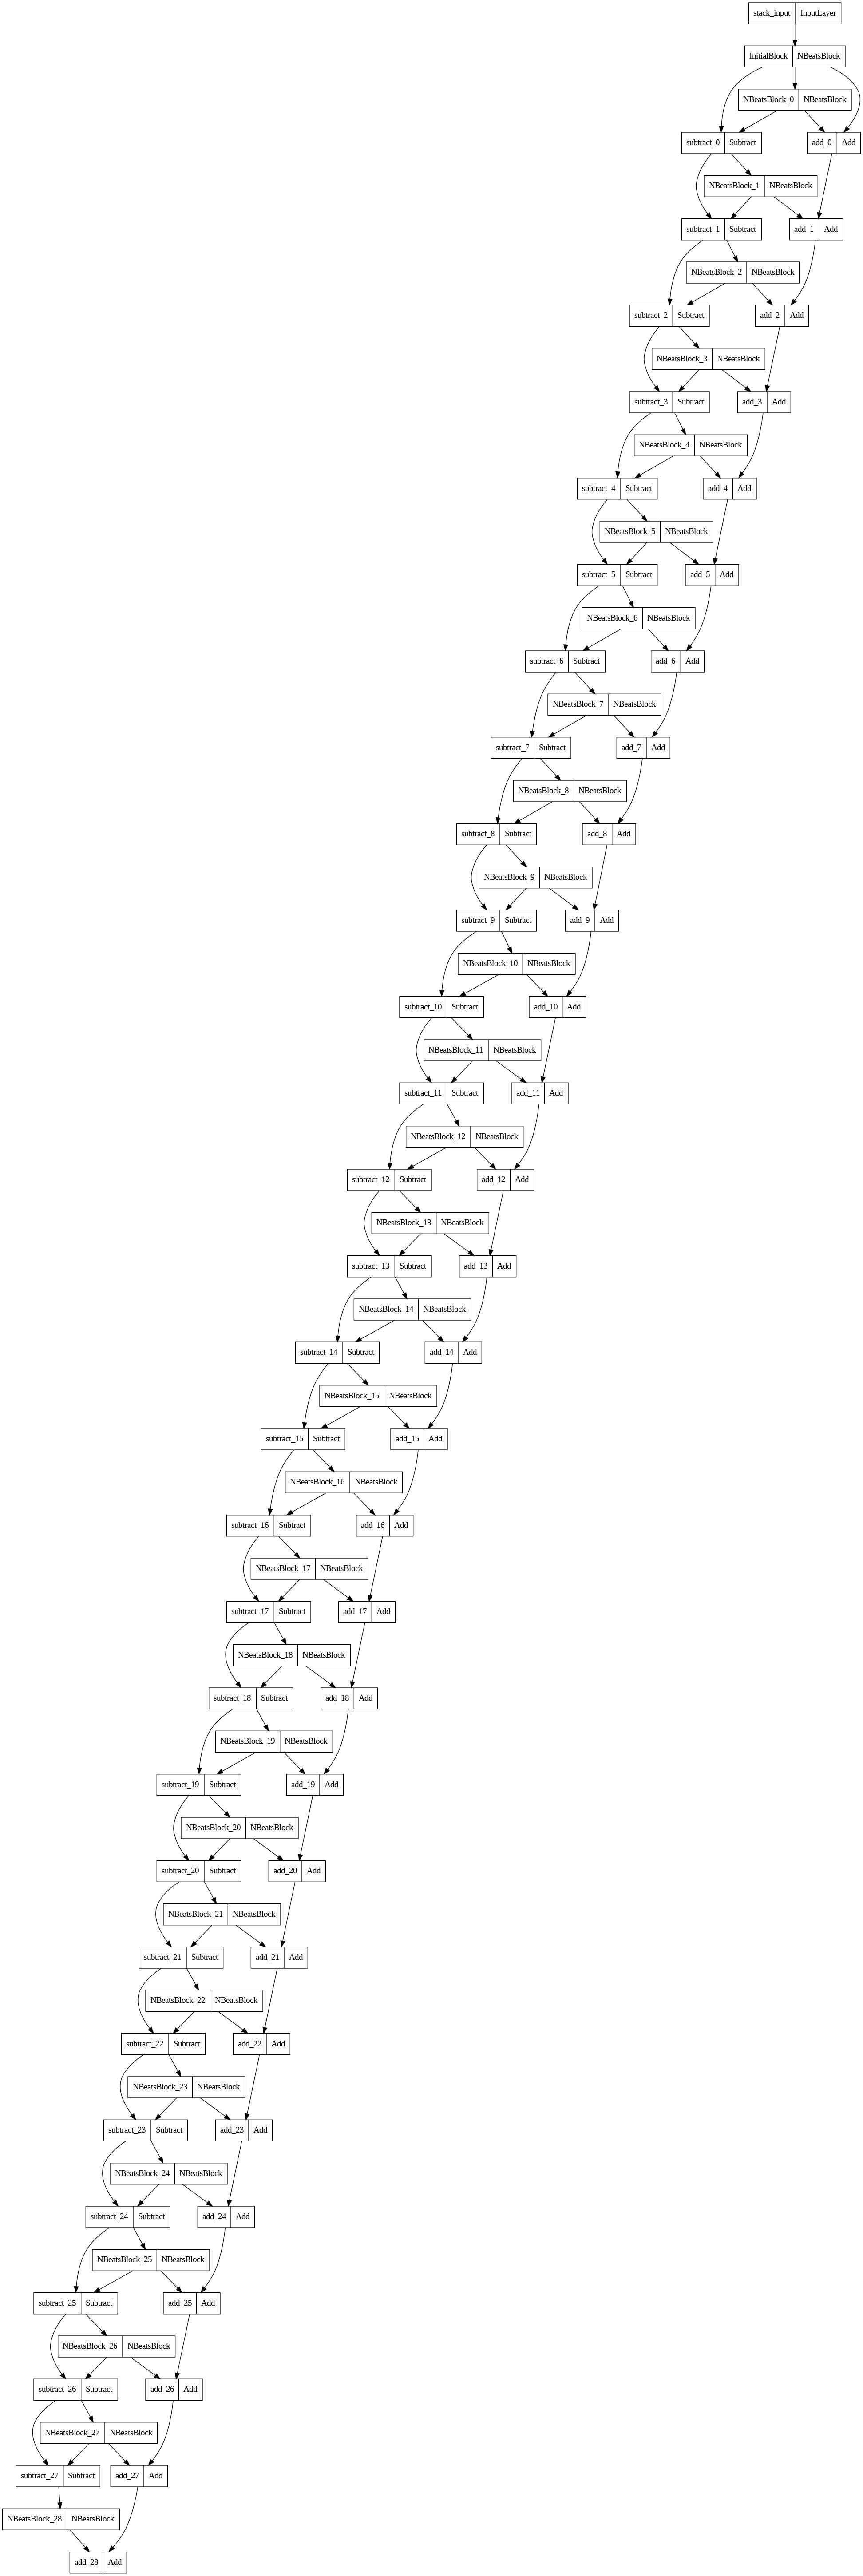

In [144]:
#Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating ensemble (stacking different model together)

An ensemble leverage the wisdom of the crowd effect.

It comvines many different models to predict a common goal

In [146]:
HORIZON, WINDOW_SIZE

(1, 7)

In [149]:
###Constructing and fitting an ensemble of models (using different loss function)

def get_ensemble_models(horizon = HORIZON,
                        train_data = train_dataset,
                        test_data = test_dataset,
                        num_iter = 10,
                        num_epochs = 1000,
                        loss_fns = ["mae", "mse", "mape"]):
  """
  return a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter = 10, a lost of 30 trained models will be returned:
  10* len(["mae","mse","mape"])
  
  """

  #Make empty list for trained ensemble models
  ensemble_models = []

  #Create num_iter number of models per loss function
  for i in range(num_iter):
    #Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number:{i}")
      #Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          #initialize dense layer with normal distribution for estimating prediction intervals later on
          layers.Dense(128, kernel_initializer="he_normal", activation = "relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation = "relu"),
          layers.Dense(HORIZON)
      ])

      #compile simple model with current loss function
      model.compile(loss = loss_function,
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics =["mae", "mse"])
      
      #fit the current model
      model.fit(train_data,
                epochs = num_epochs,
                verbose = 0,
                validation_data = test_data,
                callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                              patience = 200,
                                                              restore_best_weights = True),
                             tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                                  patience = 100,
                                                                  verbose = 1)])
      #append fitted model to list of ensemble models
      ensemble_models.append(model) 
  
  return ensemble_models



In [150]:
%%time
#get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter = 5,
                                      num_epochs = 1000)

Optimizing model by reducing: mae for 1000 epochs, model number:0

Epoch 680: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number:0

Epoch 178: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 607: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 707: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model number:0

Epoch 184: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 284: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number:1

Epoch 590: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 690: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number:1

Epoch 662: ReduceLROnPlateau

KeyboardInterrupt: ignored